In [2]:
!pip install pmdarima
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('dse_cp_BANKASIA.csv',sep=',', index_col='DATE', parse_dates=['DATE'], date_parser=dateparse).fillna(0)
stock_data
stock_data = stock_data.dropna()
print('shape of data' , stock_data.shape)
stock_data = stock_data.sort_values(by='DATE')
stock_data.head()

shape of data (245, 4)


<ipython-input-3-fbd2f277c3a5>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


,#,TRADING CODE,CLOSEP*,YCP
DATE,,,,
2022-10-16,245,BANKASIA,20.2,20.2
2022-10-17,244,BANKASIA,20.2,20.2
2022-10-18,243,BANKASIA,20.2,20.2
2022-10-19,242,BANKASIA,20.4,20.2
2022-10-20,241,BANKASIA,20.3,20.4


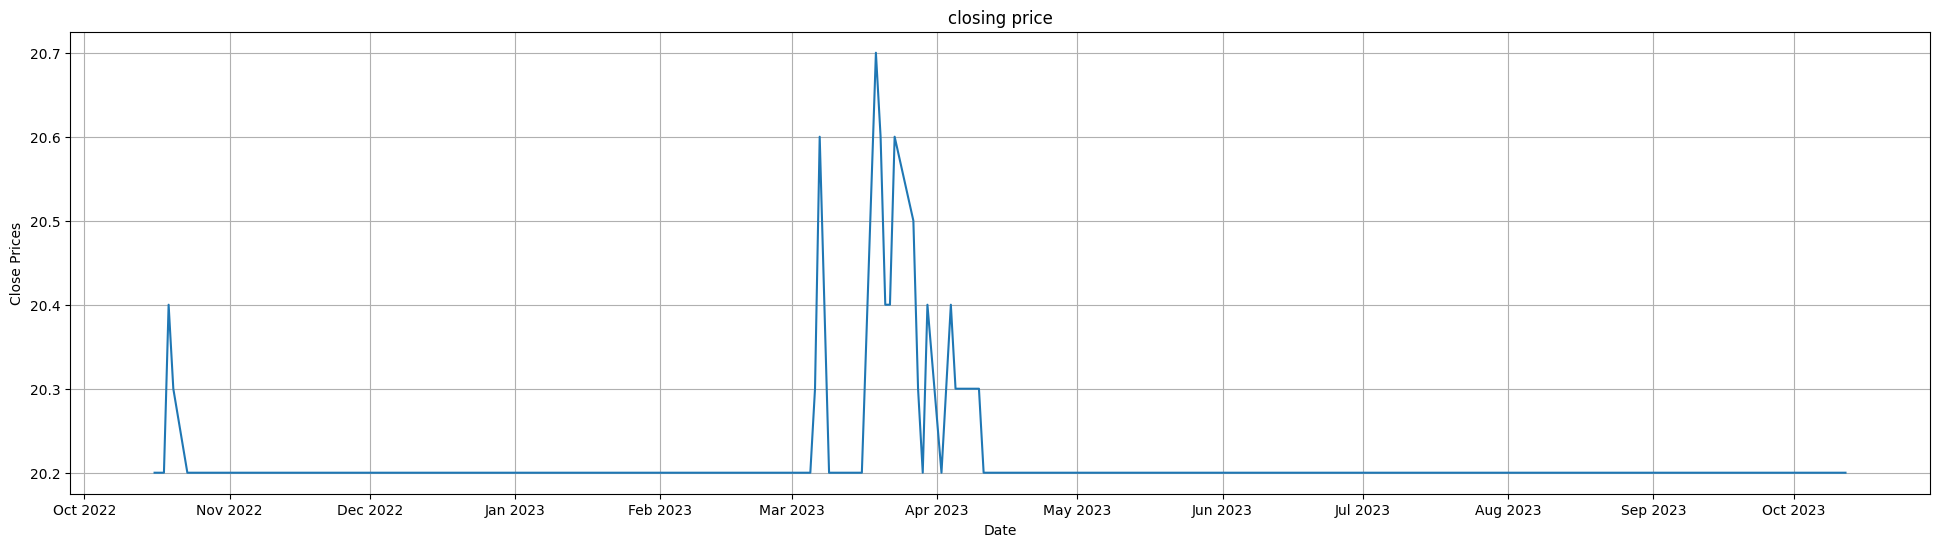

In [4]:
import matplotlib.dates as mdates
plt.figure(figsize=(24,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['CLOSEP*'])
plt.title('closing price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()

In [5]:
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("2. P-value : ",dftest[1])

In [6]:
adf_test(stock_data['CLOSEP*'])

2. P-value :  0.021883627138073448


In [7]:
df_close = stock_data['CLOSEP*']

## ***90% training data***

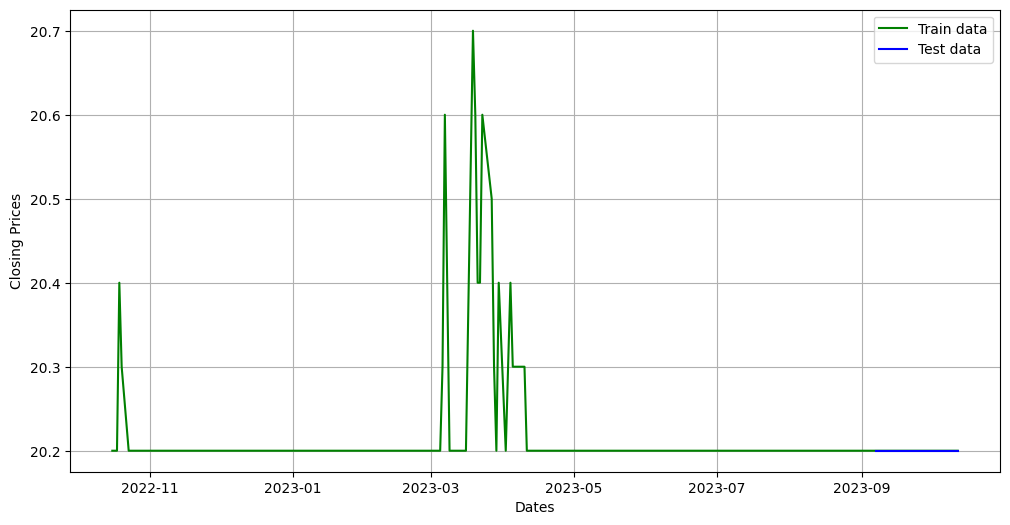

In [17]:
train_data, test_data = df_close[3:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [9]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_close, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [18]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,0,2))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_i

DATE
2023-10-12      1
2023-10-11      2
2023-10-10      3
2023-10-09      4
2023-10-08      5
             ... 
2022-10-20    241
2022-10-19    242
2022-10-18    243
2022-10-17    244
2022-10-16    245
Name: #, Length: 245, dtype: int64


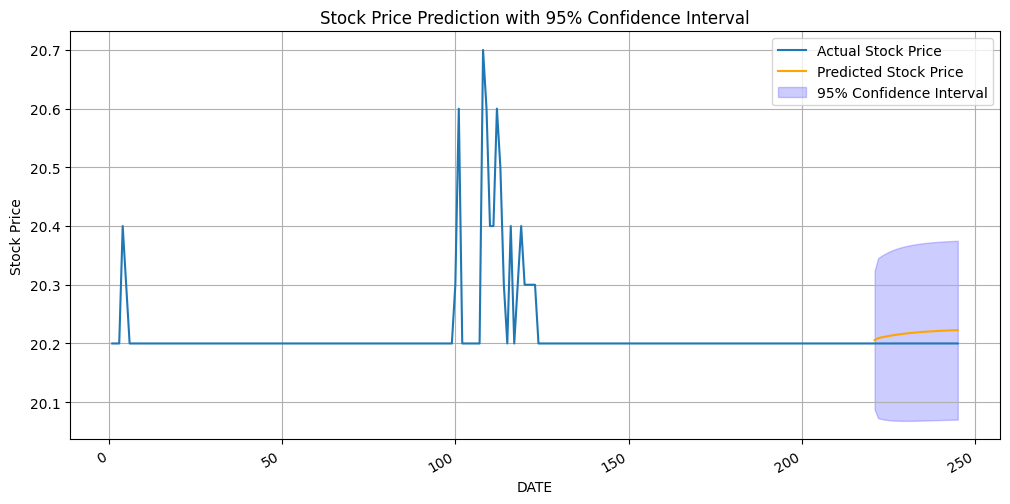

In [19]:
import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

# Calculate indices
total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

# Confidence intervals
conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 0.017994371740302093
MAE: 0.01739411157854917
MAPE: 0.0008610946326014442


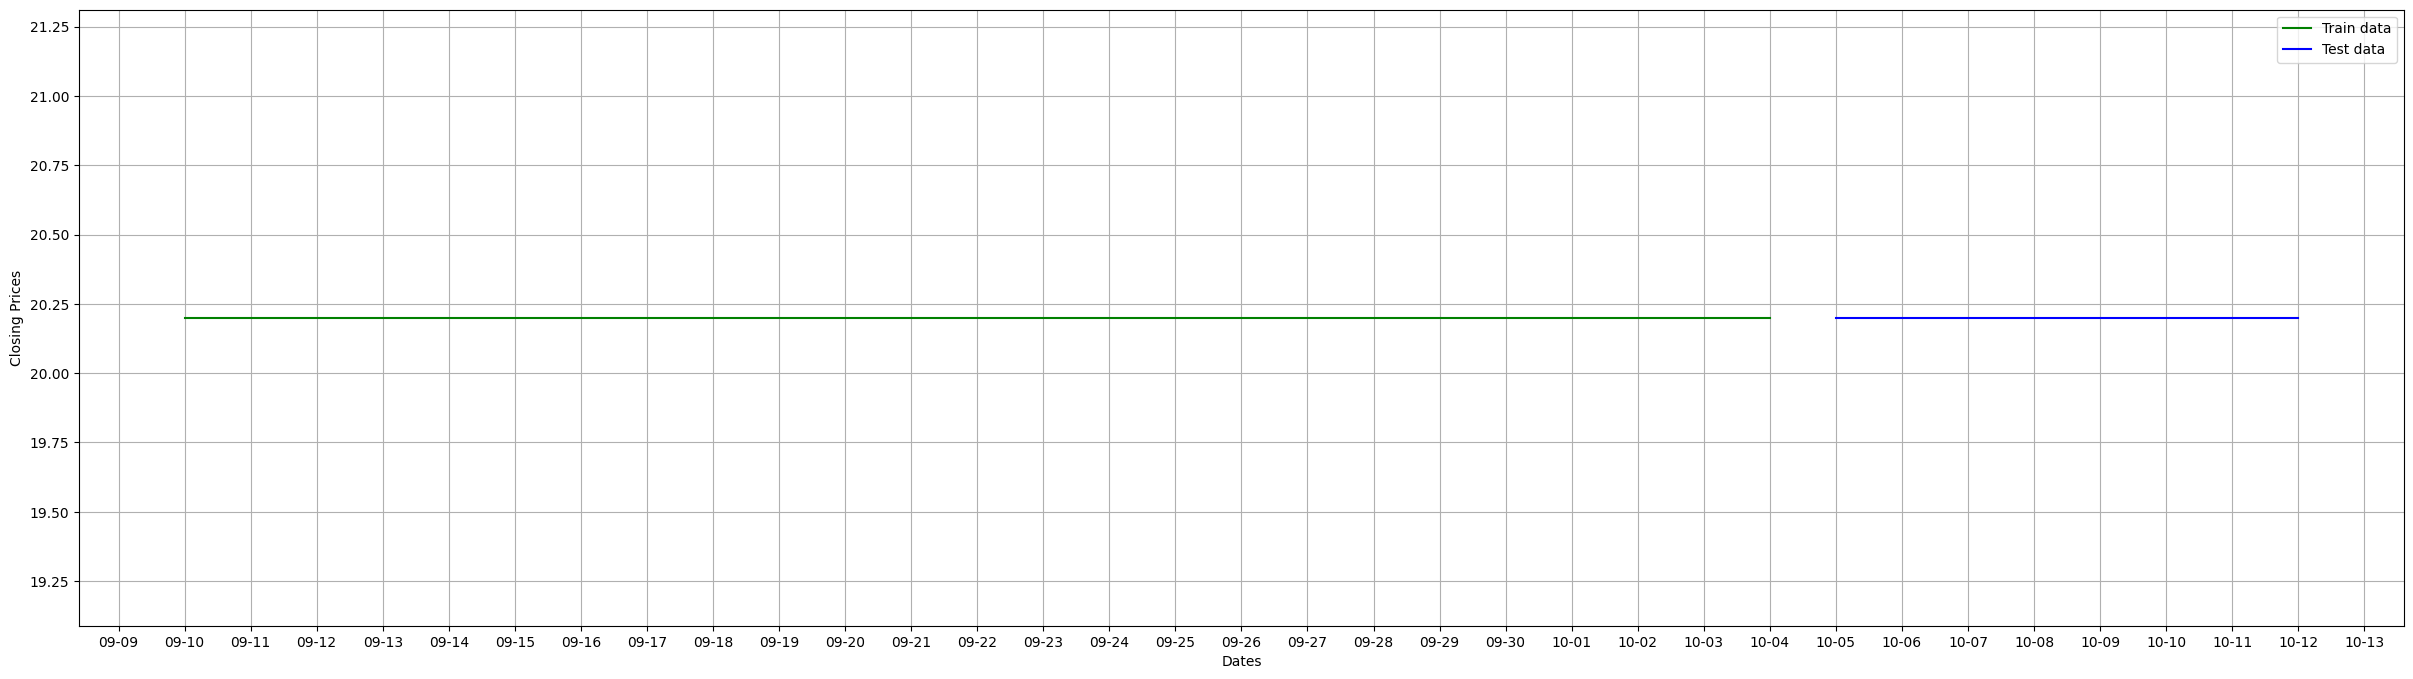

In [ ]:
last_month = df_close[-30:]
train_data = df_close[-24:-6]  # Select the last 25 days for training
test_data = df_close[-6:]     # Select the last 5 days for testing

plt.figure(figsize=(30, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')

date_format = mdates.DateFormatter("%m-%d")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend()

In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(last_month, stepwise=False, seasonal=False)
auto_arima

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,0,2))
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


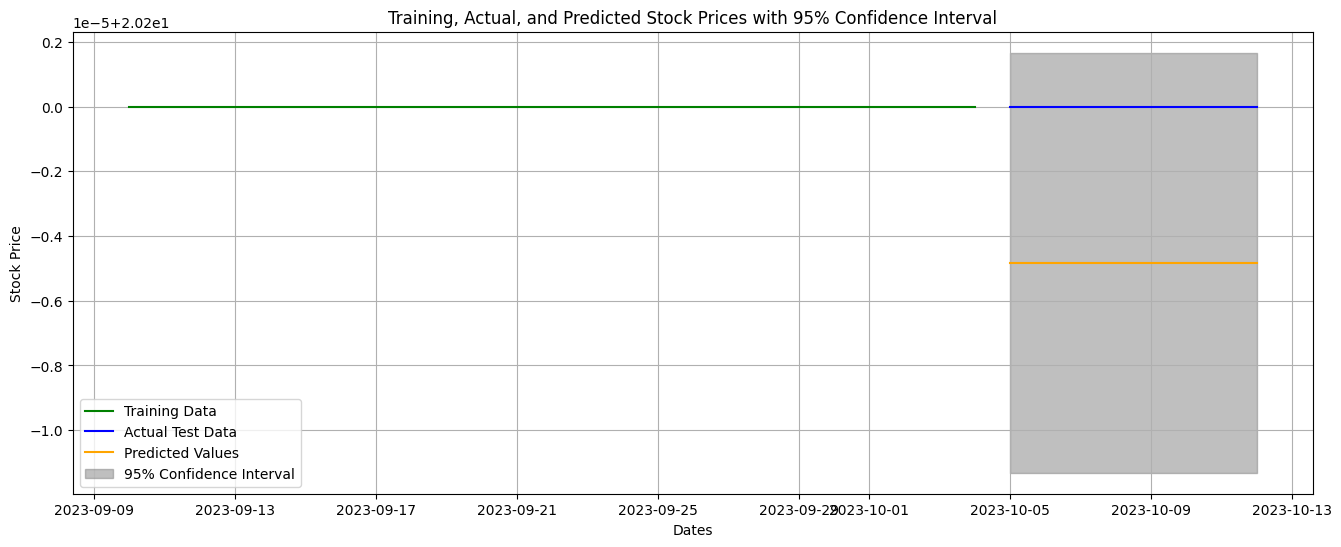

In [ ]:
conf_int = fitted.get_forecast(steps=len(test_data), alpha=0.05)

lower_ci = conf_int.summary_frame()['mean_ci_lower']
upper_ci = conf_int.summary_frame()['mean_ci_upper']

plt.figure(figsize=(16, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Stock Price')
plt.plot(train_data.index, train_data, 'green', label='Training Data')
plt.plot(test_data.index, test_data, 'blue', label='Actual Test Data')
plt.plot(test_data.index, result, 'orange', label='Predicted Values')
plt.fill_between(test_data.index, lower_ci, upper_ci, color='gray', alpha=0.5, label='95% Confidence Interval')
plt.legend()
plt.title('Training, Actual, and Predicted Stock Prices with 95% Confidence Interval')
plt.show()

import matplotlib.pyplot as plt

# Sort the stock_data DataFrame by the 'DATE' (or '#') column in ascending order
stock_data.sort_values(by='#', inplace=True)

total = len(df_close)
test = len(test_data)
train = total - test

result = fitted.forecast(test, alpha=0.05)

conf_ins = fitted.get_forecast(test).summary_frame()

# Create the plot with date labels on the x-axis and increased width
dates = stock_data['#']
print(dates)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width (12) as needed
ax.plot(dates, df_close.values, label='Actual Stock Price')
ax.plot(dates[train:], result, label='Predicted Stock Price', color='orange')
ax.fill_between(dates[train:], conf_ins['mean_ci_lower'], conf_ins['mean_ci_upper'], color='blue', alpha=0.2, label='95% Confidence Interval')
ax.set_xlabel('DATE')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price Prediction with 95% Confidence Interval')
ax.legend()
fig.autofmt_xdate()
ax.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
test_data.mean()
rmse=sqrt(mean_squared_error(result,test_data))
print("RMSE:",rmse)

mae = mean_absolute_error(test_data, result)
print("MAE:", mae)

mape = mean_absolute_percentage_error(test_data, result)
print("MAPE:", mape)

RMSE: 4.824558168081694e-06
MAE: 4.824558168081694e-06
MAPE: 2.38839513271371e-07
